# CleanTech: Transforming Waste Management with Transfer Learning

## Importing Libraries :

In [1]:
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from IPython.display import Image, display

2025-06-28 10:40:22.012592: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-28 10:40:22.020577: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-28 10:40:22.045901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751087422.086520    7377 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751087422.098589    7377 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751087422.129993    7377 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Reading & Splitting Dataset :

In [2]:
dataset_dir = '/home/uma/Smart intern project/Dataset'
classes = os.listdir(dataset_dir)
output_dir = 'output_dataset'

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)
    train_and_val, test = train_test_split(images, test_size=0.2, random_state=42)
    train, val = train_test_split(train_and_val, test_size=0.25, random_state=42)

    for img in train:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
    for img in val:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))
    for img in test:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'test', cls, img))

print("✅ Dataset successfully split into train/val/test.")


✅ Dataset successfully split into train/val/test.


## Data Preprocessing and Augmentation :

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 234 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Found 78 images belonging to 3 classes.


## Sample images : 

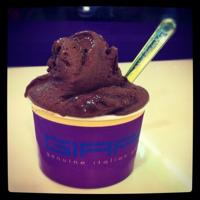

In [4]:
folder_path = '/home/uma/Smart intern project/output_dataset/train/Biodegradable Images'

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

selected_image = random.choice(image_files)

image_path = os.path.join(folder_path, selected_image)
display(Image(filename=image_path))


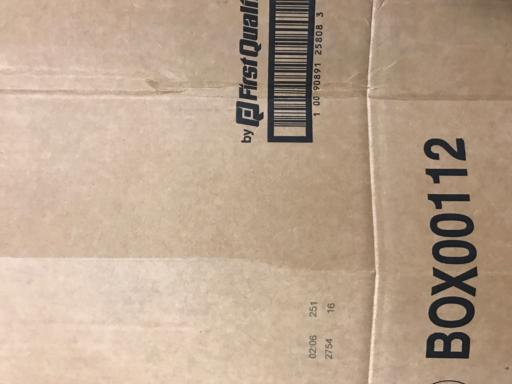

In [5]:
folder_path = '/home/uma/Smart intern project/output_dataset/train/Recyclable Images'  

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

selected_image = random.choice(image_files)

image_path = os.path.join(folder_path, selected_image)
display(Image(filename=image_path))

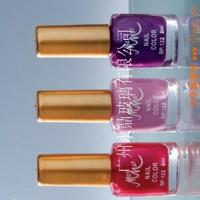

In [6]:
folder_path = '/home/uma/Smart intern project/output_dataset/train/Trash Images'  

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

selected_image = random.choice(image_files)

image_path = os.path.join(folder_path, selected_image)
display(Image(filename=image_path))

## Model Building :

In [7]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

vgg16 = Model(inputs=base_model.input, outputs=predictions)
vgg16.summary()


2025-06-28 10:40:41.744847: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           51

 Total params: 14,783,299 (56.39 MB)

 Trainable params: 7,146,755 (27.26 MB)

 Non-trainable params: 7,636,544 (29.13 MB)

## Compile and Train : 

In [8]:
vgg16.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True)
]

history = vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


/home/uma/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-06-28 10:40:52.746191: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-06-28 10:40:52.770011: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-06-28 10:40:55.201064: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-06-28 10:40:59.137322: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-06-28 10:40:59.412442: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


8/8 ━━━━━━━━━━━━━━━━━━━━ 221s 27s/step - accuracy: 0.3560 - loss: 1.6810 - val_accuracy: 0.5897 - val_loss: 1.4635 - learning_rate: 1.0000e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 204s 26s/step - accuracy: 0.4912 - loss: 1.2082 - val_accuracy: 0.6667 - val_loss: 0.7841 - learning_rate: 1.0000e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 197s 25s/step - accuracy: 0.6789 - loss: 0.7792 - val_accuracy: 0.7179 - val_loss: 0.4795 - learning_rate: 1.0000e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 196s 25s/step - accuracy: 0.7057 - loss: 0.6298 - val_accuracy: 0.7949 - val_loss: 0.3666 - learning_rate: 1.0000e-04
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 204s 26s/step - accuracy: 0.7783 - loss: 0.5639 - val_accuracy: 0.8205 - val_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 180s 23s/step - accuracy: 0.8480 - loss: 0.3559 - val_accuracy: 0.7949 - val_loss: 0.3385 - learning_rate: 1.0000e-04
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 195s 25s/step - accuracy: 0.8312 - loss: 0.4573 - v

## Plot Training History : 

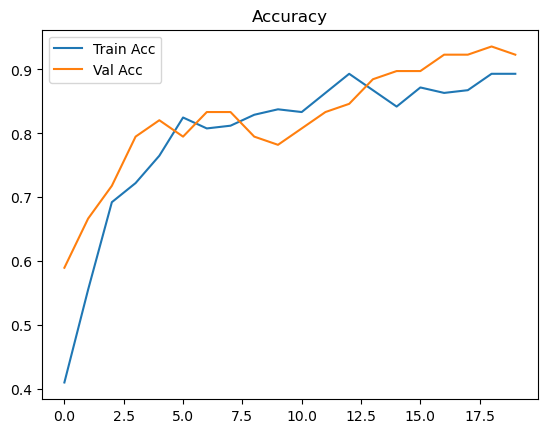

In [9]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


 ## Evaluate Model on Test Data :

In [10]:
loss, acc = vgg16.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 13s/step - accuracy: 0.9072 - loss: 0.2190
Test Loss: 0.2828
Test Accuracy: 0.8846


## Classification Report : 

In [11]:
y_probs = vgg16.predict(test_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 14s/step
Classification Report:
                      precision    recall  f1-score   support

Biodegradable Images       0.93      1.00      0.96        26
   Recyclable Images       0.88      0.85      0.86        26
        Trash Images       0.84      0.81      0.82        26

            accuracy                           0.88        78
           macro avg       0.88      0.88      0.88        78
        weighted avg       0.88      0.88      0.88        78

Confusion Matrix:
[[26  0  0]
 [ 0 22  4]
 [ 2  3 21]]


## Single Image Prediction : 

In [12]:
labels = list(train_generator.class_indices.keys())

img_path = '/home/uma/Smart intern project/output_dataset/train/Biodegradable Images/TEST_BIODEG_HFL_10.jpeg'

img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
#Predicting
preds = vgg16.predict(np.array([x]))
predicted_class = labels[np.argmax(preds)]

# Show result
print("Predicted probabilities:", preds)
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted probabilities: [[9.9993348e-01 2.4038072e-05 4.2478649e-05]]
Predicted class: Biodegradable Images


In [13]:
img_path ='/home/uma/Smart intern project/output_dataset/train/Recyclable Images/cardboard13.jpeg'  

import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)

preds = vgg16.predict(np.array([x]))
predictions=labels[np.argmax(preds)]
print("Predicted probabilities:", preds)
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicted probabilities: [[7.4854768e-05 1.8368118e-01 8.1624401e-01]]
Predicted class: Biodegradable Images


In [14]:
img_path ='/home/uma/Smart intern project/output_dataset/train/Trash Images/TRAIN.4_NBIODEG_CCW_1240.jpg'  

import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)

# Predict
preds = vgg16.predict(np.array([x]))
predicted_class = labels[np.argmax(preds)]

# Show result
print("Predicted probabilities:", preds)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
Predicted probabilities: [[1.09973716e-05 1.16781455e-04 9.99872208e-01]]
Predicted class: Trash Images


In [15]:
img_path ='/home/uma/Smart intern project/output_dataset/test/Biodegradable Images/TRAIN.2_BIODEG_ORI_113.jpg'  

import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
# Predict
preds = vgg16.predict(np.array([x]))
predicted_class = labels[np.argmax(preds)]

# Show result
print("Predicted probabilities:", preds)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicted probabilities: [[9.9382907e-01 1.6407893e-04 6.0068113e-03]]
Predicted class: Biodegradable Images


In [16]:
img_path ='/home/uma/Smart intern project/output_dataset/test/Recyclable Images/metal185.jpeg'  

import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
# Predict
preds = vgg16.predict(np.array([x]))
predicted_class = labels[np.argmax(preds)]

# Show result
print("Predicted probabilities:", preds)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicted probabilities: [[1.3790830e-04 9.6015477e-01 3.9707325e-02]]
Predicted class: Recyclable Images


##  Save Final Model :

In [17]:
vgg16.save("model.h5")
print("Model saved successfully!")

Model saved successfully!
